In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem


Generate a dataframe of SMC dft dataset

In [2]:
#Data loading
dft_source = pd.read_excel('allligands_dft_data_210125.xlsx', engine = 'openpyxl', sheet_name = "allligands_dft_data_210125")


In [3]:
#Preparing to match dft data to ligands we use in smc
#Turing smiles from smc to inchi
smc_df = pd.read_excel('smc_data.xlsx', engine = 'openpyxl', sheet_name='SMC')
#smc_inchi = smc_df['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

In [4]:
#Turning smiles from dft_source to inchi
#dft_source_inchi = dft_source['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

smc_dft_df = pd.read_excel('smc_data.xlsx', engine = 'openpyxl', sheet_name='DFT_SMC')
    

In [5]:
smc_dft_df = dft_source.loc[dft_source['ID'].isin(smc_df['Kraken ID#'])]

In [6]:
#smc_dft_df.fillna(0)
print(smc_dft_df)
smc_dft_df.to_excel("output.xlsx")  


                                                SMILES   ID  ID.1  buch    y1  \
1     CN(C)c1cccc(N(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1    2   2.0   1.0   NaN   
4               c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1    5   5.0   1.0  51.0   
5    C1C2CC3CC1CC(P(C14CC5CC(CC(C5)C1)C4)C14CC5CC(C...    6   6.0   0.0   0.0   
7                          CC(C)(C)P(C(C)(C)C)C(C)(C)C    8   8.0   0.0  40.0   
9      CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2   10  10.0   NaN   NaN   
..                                                 ...  ...   ...   ...   ...   
738  O=C(O)c1cccc(P(c2cccc(C(=O)O)c2)c2cccc(C(F)(F)...  796   NaN   NaN   NaN   
739  O=C(O)c1ccc(P(c2ccc(C(F)(F)F)cc2)c2ccc(C(F)(F)...  797   NaN   NaN   NaN   
740  O=C(O)c1ccc(P(c2ccc(C(=O)O)cc2)c2ccc(C(F)(F)F)...  798   NaN   NaN   NaN   
741                     O=Cc1ccccc1P(c1ccccc1)c1ccccc1  799   NaN   NaN   NaN   
752                                    OCCCP(CCCO)CCCO  838   NaN   NaN   NaN   

       y2    y3    y4    y5

Clean up the data
 - clear up non values
 - dropping zero-variance features and similar features

In [7]:
df = smc_dft_df.drop(columns = 'SMILES')

In [8]:
from sklearn.preprocessing import scale
# standardize
df=pd.DataFrame(scale(df),index=df.index, columns=df.columns)
# drop zero-variance features
zero_std_cols = df.columns[df.std() == 0]
df=df[df.columns.difference(zero_std_cols)]

In [9]:
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

Dropping 2 features Index(['x122', 'x125'], dtype='object')


In [10]:
# drop highly correlated features
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 78 features ['ID.1', 'ID.2', 'x100', 'x107', 'x108', 'x110', 'x111', 'x112', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x124', 'x130', 'x133', 'x134', 'x135', 'x137', 'x138', 'x14', 'x140', 'x142', 'x145', 'x146', 'x147', 'x150', 'x152', 'x153', 'x155', 'x159', 'x160', 'x168', 'x192', 'x22', 'x29', 'x4', 'x41', 'x42', 'x48', 'x49', 'x61', 'x62', 'x63', 'x64', 'x65', 'x69', 'x7', 'x71', 'x72', 'x73', 'x74', 'x75', 'x78', 'x8', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x96', 'x97', 'x98', 'x99', 'y15', 'y16', 'y18', 'y19', 'y5', 'y7', 'y8', 'y9']


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#Arbitrarily assign 0 value to all NaN spaces
df.replace(np.nan, 0)
#Dropping some of the incomplete/useless parts of dataset
try:
    df = df.drop(columns = ['ID','Unnamed: 110','y1','y2','y3','y4','buch'])
    df = df.drop(columns = ['y6','y10','y11','y12','y13','y14','y17'])
    df = df.drop(columns = ['y15','y16','y18','y19','y5','y7','y8','y9'])
except:
    pass
#df.to_excel("output.xlsx")  


UMAP Dimension Reduction to 2

In [12]:
from sklearn.decomposition import PCA
from umap import UMAP
# define the dimensionalities of the reduced representation to study
dims = [80, 50, 20, 10, 5, 2]
# dictionary to store data at different levels of dimensionality reduction
dfs={}
# UMAP section
n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=0).fit_transform(df), index=df.index)
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


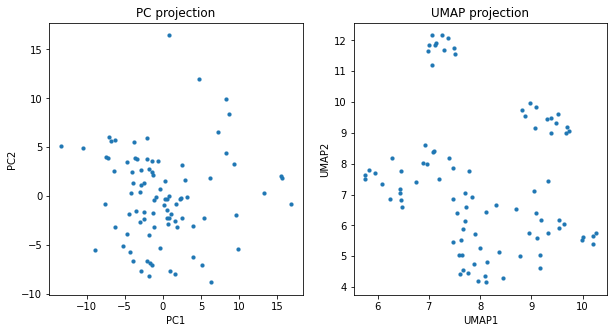

In [13]:
# Visualize the embeddings
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
_= sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=1, linewidth=0.25,  edgecolor='face', ax=ax[0]).set_title("PC projection")
_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=1, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")

Clustering

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score
# Define the numbeor of clusters to study
N_CLS_list = list(range(5, 41))
def silhouette_scores_hierarchical(data, n_cls_list):
 """helper function to compute a silhouette score for hierarchical cluster
ing using Ward linkage"""
 
 z = linkage(data, method='ward')
 
 result = pd.Series(index=n_cls_list, dtype=float)
 for n_cls in n_cls_list:
    cls = fcluster(z, n_cls, criterion='maxclust')
    result.loc[n_cls] = silhouette_score(data, cls)
 return result


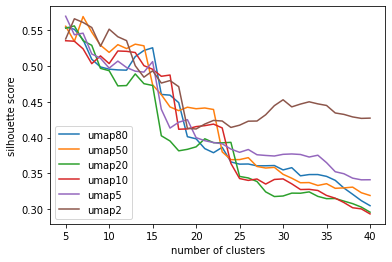

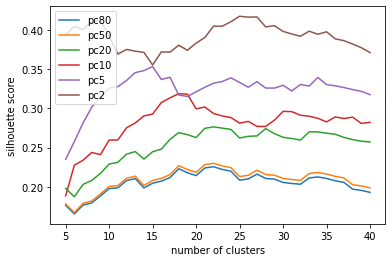

In [15]:
# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
# plot the silhouette scores
_=silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(
xlabel='number of clusters',ylabel='silhouette score')


Final Clustering

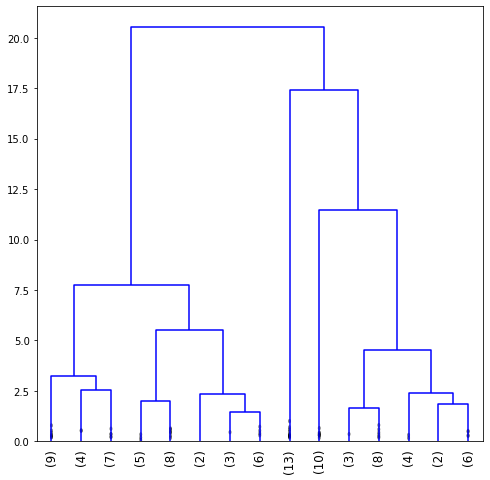

In [16]:
# final number of clusters to produce
NCLS = 15
# linkage and clustering for selected featurization
z = linkage(dfs['umap10'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')
# plot the dendrogram
plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True, leaf_rotation=90, color_threshold=0)


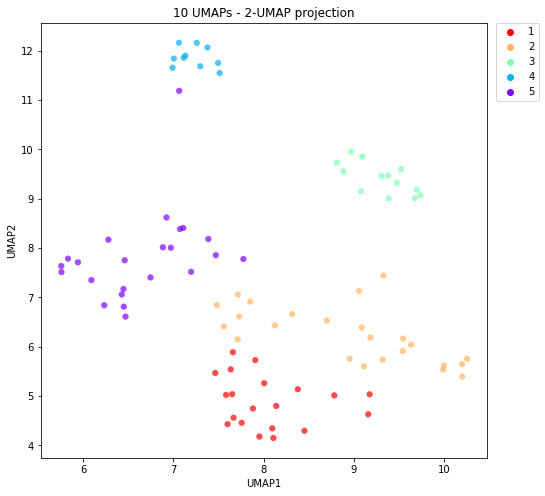

In [17]:
# plot clustering
NCLS = 5
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


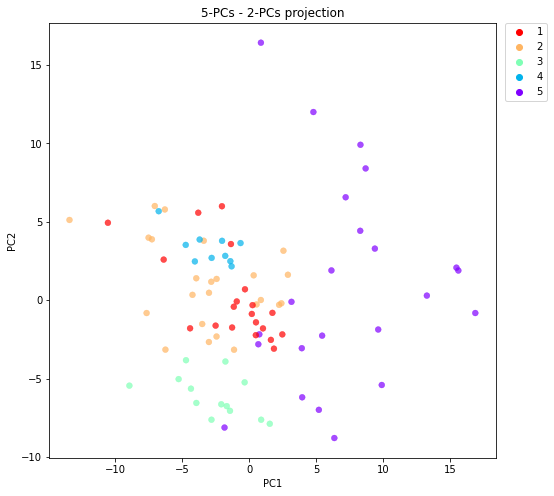

In [18]:
# plot clustering
NCLS = 5
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.4, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("5-PCs - 2-PCs projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

In [19]:
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    rxns = []
    smiles = df['SMILES']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns

Cluster 1, n molecules: 20


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


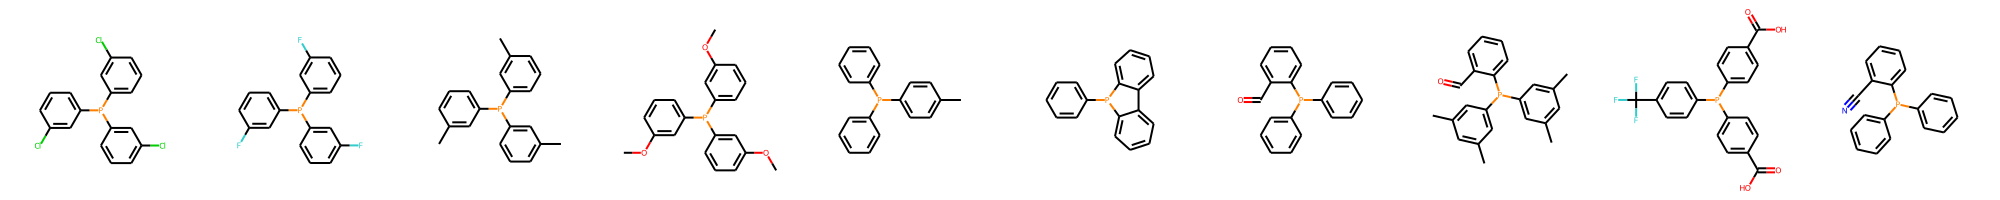

Cluster 2, n molecules: 24


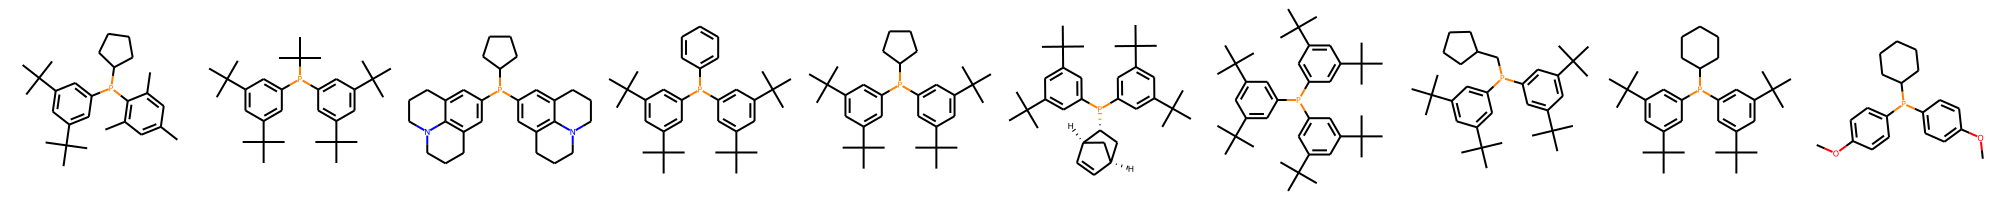

Cluster 3, n molecules: 13


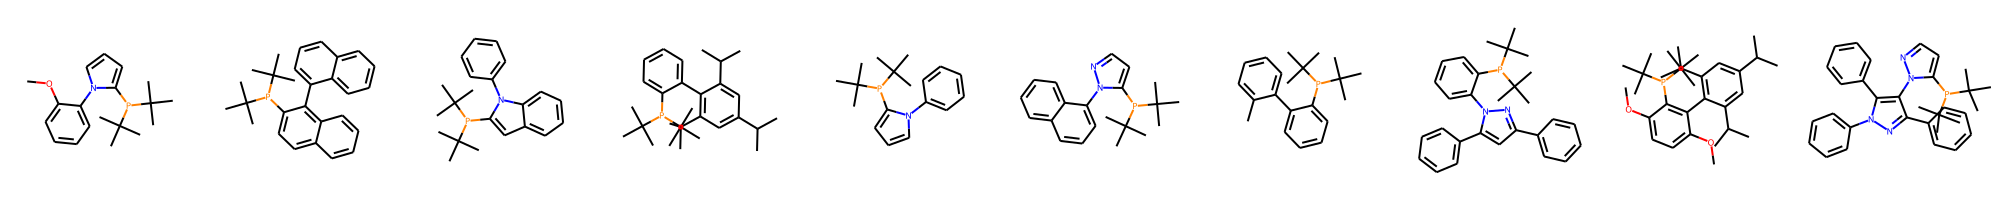

Cluster 4, n molecules: 10


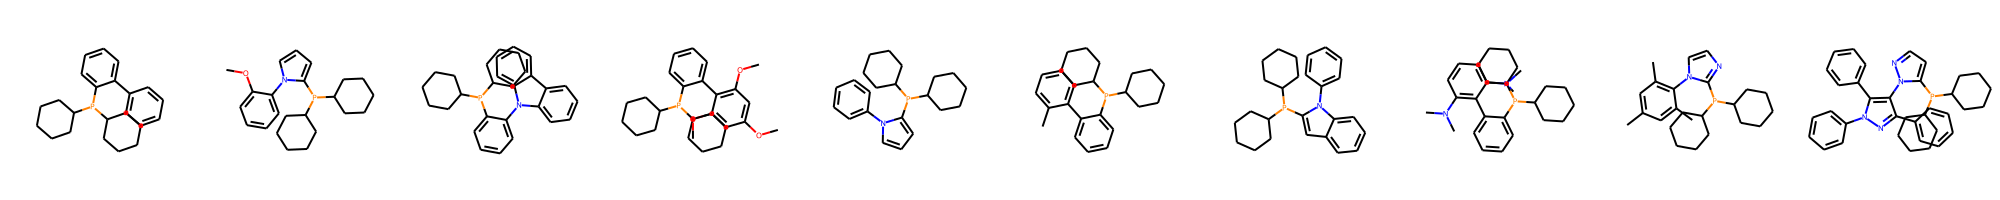

Cluster 5, n molecules: 23


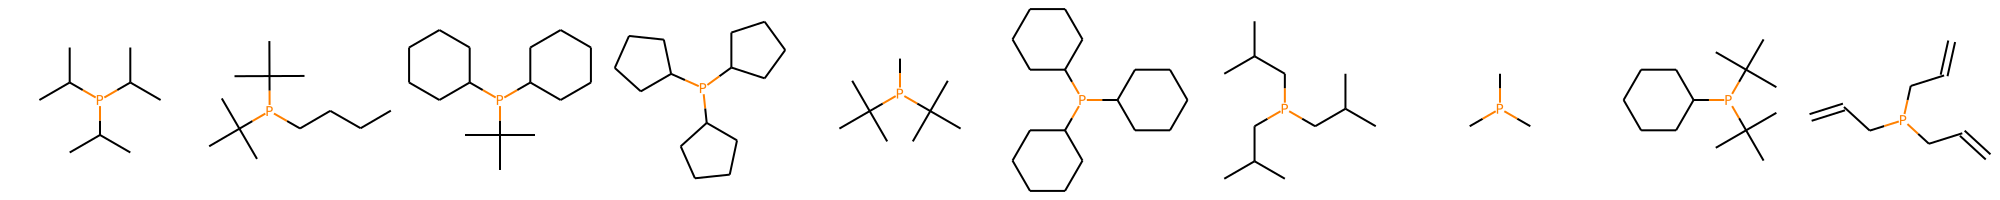

In [24]:
from scipy.spatial.distance import cdist
from rdkit.Chem import Draw
# build rdkit molecules for all candidates
df = smc_dft_df
df['mol'] = generate_ligand_data(df)
mols = pd.Series(((df['mol'])), index=df.index).to_frame('mol')
features='umap2'
# How many central molecules to display?
n_per_cluster = 10
# store central candidates for 
cands=[]
for group, data in mols.groupby(cls):
 # get descriptor data for this cluster
 desc_data=dfs[features].loc[data.index]
 
 # compute distances of these molecules to their center
 dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
 index=desc_data.index)
 # select top n central molecules
 selected=dists.sort_values().head(n_per_cluster).index
 
 smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
 smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
 cands.append(smi)
 
 print (f"Cluster {group}, n molecules: {len(data)}")
 ms = data['mol'].loc[selected]
 display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
 
cands = pd.concat(cands, axis=1)

# MLR on Reduced dimensions

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
dfs

{'umap80':            0         1         2         3         4         5         6   \
 1    8.342345  2.178605  3.613731  6.170775  5.353010  5.015412  0.907392   
 4    8.375757  2.129018  3.506778  6.196294  5.405983  4.991737  0.793893   
 5    7.972260  2.086283  4.449376  5.491446  4.350177  5.061334  1.699954   
 7    7.930164  2.033734  4.452174  5.491498  4.347344  5.045451  1.786487   
 9    8.010397  2.122694  4.411149  5.478743  4.382099  5.062041  1.595045   
 ..        ...       ...       ...       ...       ...       ...       ...   
 738  8.019920  2.149975  3.892228  5.445805  4.284812  4.859007  1.232666   
 739  7.956830  2.154515  3.920403  5.427857  4.196292  4.845724  1.276412   
 740  7.971385  2.167356  3.916311  5.365846  4.187028  4.843570  1.244549   
 741  7.984046  2.159646  3.938296  5.399398  4.173300  4.860077  1.275955   
 752  8.031381  1.954430  4.220226  5.598004  4.605437  4.906344  1.498628   
 
            7         8         9   ...        70   

In [23]:

df_prep = pd.read_excel('smc_data_catagorized.xlsx', sheet_name='UMAP5') 



ValueError: Worksheet named 'UMAP5' not found

In [ ]:
df_prep

,Unnamed: 0,col0,col1,col2,col3,col4,II,III,IV,V,RS1
0,1,10.405980,9.949491,5.177228,2.137312,4.516526,3,0,0,25,3
1,4,10.184149,9.880013,5.303159,2.379343,4.921727,67,3,9,89,100
2,5,8.496016,7.073065,4.316756,4.362314,5.037047,2,0,1,14,2
3,7,8.597063,7.554504,4.490983,4.459729,5.220729,2,0,0,16,2
4,9,8.763071,7.181123,3.909582,4.214484,4.715596,9,4,1,26,6
...,...,...,...,...,...,...,...,...,...,...,...
85,738,8.855224,5.850530,1.965670,3.223423,2.365973,0,0,0,2,0
86,739,8.638846,5.632144,1.975634,3.502118,2.235797,1,0,0,3,1
87,740,8.679667,5.426002,2.101147,3.510531,2.347368,0,0,0,2,0
88,741,8.525442,5.435060,2.278694,3.845977,2.502709,0,0,0,5,0


In [ ]:
df_prep = df_prep.sample(frac=1,random_state=4)
df_y = df_prep['II']
df_x = df_prep[['col0','col1','col2','col3','col4']]

In [ ]:
X_train,X_test = df_x[:71],df_x[71:]
print(X_train.shape,X_test.shape)


(71, 5) (19, 5)


In [ ]:
mean = df_y.mean()
std = df_y.std()

y_train = ((df_y - mean) / std).tolist()[:71]
y_test = ((df_y - mean) / std).tolist()[71:]
df_y = (df_y - mean)/std

In [ ]:
from sklearn import linear_model
def linear_reg_of_n_features(df_x,df_y):
    reg=linear_model.LinearRegression()     #initiating linearregression
    model = reg.fit(df_x,df_y)
    Intercept=reg.intercept_
    Coefficients=reg.coef_
    return Intercept, Coefficients, model

In [ ]:
Intercept, Coefficients, model = linear_reg_of_n_features(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

reg_predictions = model.predict(X_train)
reg_mse = mean_squared_error(y_train, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

reg_predictions2 = model.predict(X_test)
reg_mse2 = mean_squared_error(y_test, reg_predictions2)
reg_rmse2 = np.sqrt(reg_mse2)
print("Test set RMSE:",reg_rmse2)

r2_score2=r2_score(y_train, reg_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, reg_predictions2)
print("Test set R^2:",r2_score3)

Training set RMSE: 0.7630900277984606
Test set RMSE: 0.7761436840284203
Training set R^2: 0.4186108155831383
Test set R^2: 0.3580992008328461


In [ ]:
def evaluate_model_of_n_features(train_x,train_y,test_x,test_y,model):
    reg_predictions = model.predict(train_x)
    train_mse = mean_squared_error(train_y, reg_predictions)
    train_rmse = "{:.2f}".format(np.sqrt(train_mse))

    reg_predictions2 = model.predict(test_x)
    test_mse = mean_squared_error(test_y, reg_predictions2)
    test_rmse = "{:.2f}".format(np.sqrt(test_mse))

    train_r2="{:.2f}".format(r2_score(train_y, reg_predictions))
    test_r2="{:.2f}".format(r2_score(test_y, reg_predictions2))
    return train_rmse, test_rmse, train_r2, test_r2

In [ ]:
from sklearn.model_selection import cross_val_score

def fold_5_cross_validation(df_x,df_y):
    train_x = df_x[:(int((len(df_x)*0.79)))]
    train_y = df_y[:(int((len(df_x)*0.79)))]
    test_x = df_x[(int((len(df_x)*0.79))):]
    test_y = df_y[(int((len(df_x)*0.79))):]
    Intercept, Coefficients, regg = linear_reg_of_n_features(train_x,train_y)
    print('Intercept:',Intercept,', Coefficient: ',Coefficients)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_n_features(train_x,train_y,test_x,test_y,regg)
    print('Training set RMSE:',train_rmse, '\nTest set RMSE: ',test_rmse, '\nTraining set R^2:',train_r2, '\nTest set R^2: ',test_r2 )
    cvd_scores = cross_val_score(regg, df_x, df_y, cv=5)
    print('5 fold Cross Validation score: ',cvd_scores)

In [ ]:
fold_5_cross_validation(df_x,df_y)

Intercept: -13.020634648685421 , Coefficient:  [ 1.67156862 -0.85368039  0.23369379 -0.03015759  0.76767271]
Training set RMSE: 0.76 
Test set RMSE:  0.78 
Training set R^2: 0.42 
Test set R^2:  0.36
5 fold Cross Validation score:  [0.32613168 0.22791437 0.22206178 0.42019606 0.35843141]
